# FlowNet : Learning Optical Flow ith Convolutional Networks

`Philipp Fishcher`
`Alexey Dosovitskiy`

# FlowNet 2.0 : Evolution of Optical Flow Estimation with Deep Networks
`Eddy Ilg`
`Nikolaus Mayer`

---

# 0. OverView

## FlowNet

optical flow를 convolution neural net으로 추측하는 model
![FlowNet](img/07_1.png)
![FlowNet](img/07_2.png)
## FlowNet2.0

![FlowNet2](img/07_3.png)

---
# 1. Optical Flow

## 1.1 Optical Flow(광학흐름)

광학흐름(optical flow)는 어떤 물체의 표면(surface)혹은 모서리(edge)의 움직임(Motion)을 나타내는 Vector Map을 말한다. 

---
![optical_flow](img/01_1.png)
    <center>출처 : [http://of-eval.sourceforge.net/](http://of-eval.sourceforge.net/)</center>

왼쪽 이미지에서 오른쪽 이미지로의 움직임(회전)을 가지는 두 이미지에서의 optical flow는 가운데와 같이 나타 낼 수 있다.

이미지에서의 optical flow는 각 pixcel당 x,y방향의 벡터값을 가진다. 2d voxcel과 같다.

---


화살표로 optical flow를 표현할때, 모든 픽셀에 대해 표현하면 보기가 힘들기 때문에 주로 color map을 이용하여 표현한다. 

![OpticalFlow_ColorMap](img/02.png)


![03_00](img/03_00.png)
![03_01](img/03_01.png)
![03_02](img/03_02.png)
<center>출처 : KITTI data set</center>


## 1.2 Basic Optical Flow Estimation

- [Wikipedia](https://en.wikipedia.org/wiki/Optical_flow)를 참고하여 작성하였습니다.

---

Optical Flow를 기본적인 컨셉은 다음과 같다.

- $t$시간일 때, $x,y$ 위치에 있는 image의 값을 $I(x,y,t)$라고 할 때, $\Delta{t}$ 동안 $\Delta{x},\Delta{y}$만큼 움직였을 때, 밝기는 변하지 않고 위치만 움직였다고 가정하면 다음과 같이 표현 할 수 있다.

![](img/04_01.png)

- 여기서 $I(x,y,t)$를 Taylor series로 표현하면, 

![](img/04_02.png)

- Higher order term을 무시하고, $I(x,y,t) = I(x+\Delta{x}, y+\Delta{y}, t+\Delta{t})$ 이므로.

![](img/04_03.png)

- $\Delta{t}$로 나누어주면.

![](img/04_04.png)

- $ V(x) = \frac{\Delta{x}}{ \Delta{t}}, V(y) = \frac{ \Delta{y} }{ \Delta{x}}$ 로 바꾸면

![](img/04_05.png)

- 결국 각각 Image의 x,,y,t 방향으로의 편미분을 $I_x, I_y, I_t$ 로 바꾸면.
![](img/04_06.png)
- 이를 행렬식으로 바꾸면 다음과 같이 바꿀수 있다.
![](img/04_07.png)


In [38]:
import numpy as np
from scipy.signal import convolve2d as conv


def optical_flow(img1,img2):
    kernel_x = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
    kernel_y = np.array([[-1,-1,-1],[0,0,0], [1,1,1]])
    
    I_x = conv(img1,kernel_x, mode='same')
    I_y = conv(img1,kernel_y, mode='same')
    I_t = img2-img1

    A = np.vstack((I_x.flatten(), I_y.flatten())).T
    b = I_t.reshape(1,-1).T

    # np.linalg : linear algbra
    # pinv : 역행렬
    nu = np.linalg.pinv(A).dot(b)
    
    return nu 

[[0.16666667]
 [0.16666667]]


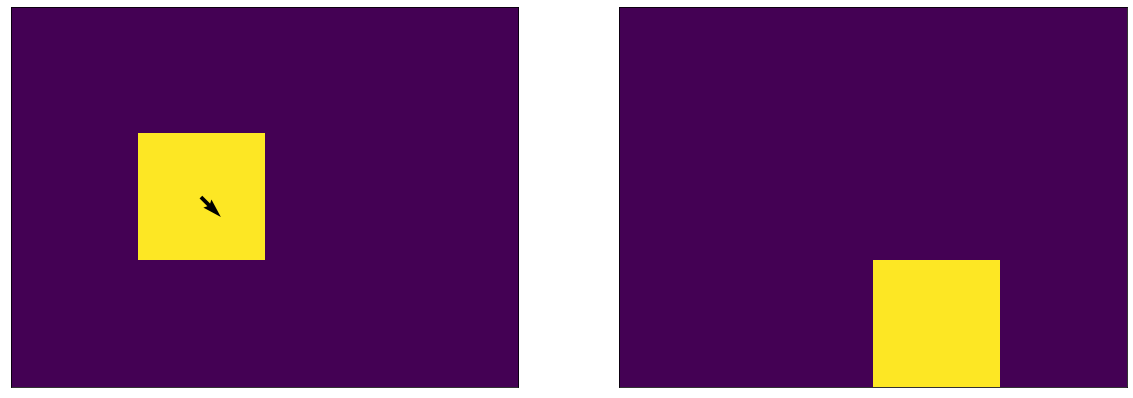

In [39]:
import matplotlib.pyplot as plt


img1 = np.array([[0,0,0,0],
                 [0,1,0,0],
                 [0,0,0,0]])

img2 = np.array([[0,0,0,0],
                 [0,0,0,0],
                 [0,0,1,0]])

nu = optical_flow(img1,img2)
print(nu)

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])

# vector를 화살표로 그려주는 함수
plt.quiver(1,1, nu[0], -nu[1]) # pyplot 에서는 아래가 양수이므로, 방향을 바꿔준다.

plt.subplot(1,2,2)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])

plt.show()

## 1.3 Lucas-Kanade method

 위의 식(코드)로 했을 때의 문제는 이미지에 대해 하나의 vector만 나온다는 것이다. 따라서 위의 constraint를 기본으로 optical flow를 구하는 여러 알고리즘이 있는데, 그중에 대표적인 Lucas-Kanade 방법을 소개한다.
 
- Lucas-Kanade 방법은 window를 씌워 각 window별로 flow vector를 구하는 것이다.
![](img/05.png)



## 1.4 Optical Flow challenges


### - Aperture problem

조리개와 같이 작은 부분을 통해 본 움직임의 방향을 확정지을 수 없다. 

![](img/Aperture_Problem.gif)


**Horn-Schunck method**
![](img/10.png)

---
    
### - Large displacement

큰 움직임일 경우 에러가 크게 발생하는 문제

Higher order term을 무시하고, first-order-taylor로 approximation하였기 때문에, short displacement가 전제된다. 따라서 Large displacement인 경우 에러가 많이 발생한다. 


**EpicFlow [CVPR2015]**


---

# 2. FlowNet

## 2.1 Dataset : Flying Chairs

당시 optical flow를 supervised learning으로 학습하기 위한 데이터가 부족했기 때문에 논문에서, 학습을 위해 만든 데이터셋을 같이 소개하였다.

![](img/09.png)

Flickr + chair

![FlyingChairs](img/08.png)

<center>출처 : https://lmb.informatik.uni-freiburg.de/resources/datasets/FlyingChairs.en.html </center>


## 2.2 Model : Simple and Correlation

논문에서는 두가지 모델을 제시한다. 각각 Simple 과 Correlation으로, 두 모델 모두 image 2장을 input으로 하여 optical flow를 예측하는 모델이다.

### - FlowNetSimple

Simple 모델은 두 Image를 Concat하여 Convolutional 모델에 넣어 학습한다. Input이 6채널(RGB 3채널이 두개)인 부분을 제외하고 일반적인 CNN의 모습과 같다.

![flownet_simple](img/07_1.png)

이론적으로는 네트워크가 충분히 크다면, optical flow를 잘 예측할 수 있지만. SGD를 통해 그 지점으로 갈 수 있을 지 확신할 수 없다. 그러므로 덜 일반적이지만, 유용한 hand-design적인 구조로 학습한다면 좀더 나은 성능을 보일 수 있을 것이다. 


### - FlowNetCorr

Corr 모델은 각각의 image에 대해 feature를 어느정도 뽑아낸 후, 논문에서 제시하는 corr 연산을 통해 합쳐준다. 이후 다시 convolution layer를 반복하여 optical flow를 예측한다.


![flownet_corr](img/07_2.png)



#### - corr 연산 : 

corr 연산은 두 feature map을 비교를 하기 위한 연산이다.

feature map f1의 x1와 feature map f2의 x2에 대한 corr 연산은 다음과 같이 정의 된다.

![corr](img/11.png)

corr 연산은 쉽게 말해, feature map을 또 다른 feature map을 kernel(혹은 filter)로 convolution 하는 연산을 말한다.
(논문에서 muliplicative path comparisons라고 표현되어있다....)

아래의 그림은 corr 연산을 표현한 것으로, 여기서 K는 patch의 사이즈를 뜻한다.
모든 범위에 대해 연산을 수행하면 연산량이 너무 많으므로, 제한된 범위 D를 설정하여 해당 범위에 대해서만 연산을 수행한다.

![corr_img](img/12.png)



### Refinement

FlowNet은 unet과 같이, 앞에서 수행한 convolution layer들의 output들을 이후 upconvolution layer를 수행할 때 input과 concat하여 사용한다.

![refinement](img/13.png)

또한 upconvolution에 앞서, 작은 scale의 predict layer(flow_n)를 수행하고, 이 정보를 다음 upconvolution layer에 넘겨주어 사용한다.


loss는 EPE(end point error) loss를 사용 (= L2 loss)

## 2.3 Result

기존의 연산에 비해 성능은 조금 떨어지나, 연산 시간에 이점이 크다.

![14](img/14.png)

- ft : fine - tuning
- v : variational loss 추가


![15](img/15.png)

---

# 3. FlowNet2

## 3.1 Dataset : Flying Things 3D

![](img/16.png)

## 3.2 Stacking Networks

- SOTA 방식들이 모두 iterative method인 점을 생각하여 network를 iterative 하게 해보자는 아이디어에서 출발

![FlowNet2](img/07_3.png)

- 두 네트워크를 쌓고 테스트하였을 때, Warped image를 넣어주면 성능이 증가한다는 결과를 고려하여 warped image를 input에 추가함 <br>warped image : 예측한 optical flow를 두번째 이미지에 bilinear한 방법으로 연산하여 만든 이미지

- 네트워크를 쌓았을 때의 small displacement에 취약하여, small displacement를 따로 학습하는 모델을 추가. 

## 3.3 Result

FlowNet2는 SOTA 방식과 비교하여 비슷한 성능을 내지만, 더욱 빠름.

![](img/17.png)
![](img/18.png)